# Enhanced MLP Edit and Test Suite

This notebook tests both the original heuristics and new heuristics we've implemented:

## New Edit Heuristics:
- **GradientBased**: Uses gradient magnitudes to identify important weights
- **LayerImportance**: Uses ablation studies to find important layers  
- **NeuronPruning**: Targets weights connected to low-activation neurons
- **Adversarial**: Uses adversarial examples to find vulnerable weights
- **Random**: Random baseline for comparison

## New Set Heuristics:
- **ConfidenceBased**: Focuses on low-confidence predictions
- **BoundarySamples**: Targets samples near decision boundaries
- **ClusteringBased**: Groups similar samples using clustering
- **HardNegativeMining**: Focuses on highest-loss samples
- **ProgressiveDifficulty**: Combines easy and hard samples

In [1]:
import models
import torch

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import torch

from edit_heuristics import (
    FromLayerHeuristic, SingleLayerHeuristic, ActivationBased, WeightsActivationBased,
    GradientBasedHeuristic, LayerImportanceHeuristic, NeuronPruningHeuristic, 
    AdversarialHeuristic, RandomHeuristic
)
from set_heuristics import (
    SetHeuristic, SubsetSetHeuristic, SimilaritySetHeuristic, MisclassifiedSetHeuristic, 
    ByClassSetHeuristic, FullDatasetHeuristic, ConfidenceBasedHeuristic, 
    BoundarySamplesHeuristic, ClusteringBasedHeuristic, HardNegativeMiningHeuristic, 
    ProgressiveDifficultyHeuristic
)
from IPython.display import clear_output

from train import train_combinations

ROOT = "./data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"{ROOT}/moon_classifier_mlp.pth"
DATASET_PATH = f"{ROOT}/moon_dataset.pt"
EDITSET_PATH = f"{ROOT}/moon_misclassifications.pt"
EDITED_MODEL_PATH = f"{ROOT}/moon_classifier_mlp_edited.pth"

original_model = models.mlp(path=MODEL_PATH)
moon_data = torch.load(DATASET_PATH)
moon_dataset = torch.utils.data.TensorDataset(moon_data['features'], moon_data['labels'])

# Get the test data features and labels from the moon_dataset
X = moon_data['features']
y = moon_data['labels']

# Define all heuristic options (including original ones)
edit_heuristics_options = [
    ("SingleLayer", SingleLayerHeuristic(layer_idx=2, lb=-0.5, ub=0.5)),
    ("FromLayer", FromLayerHeuristic(start_layer=-1, lb=-0.5, ub=0.5)),
    ("ActivationBased", ActivationBased(dataset=moon_dataset, lb=-0.5, ub=0.5)),
    ("WeightsActivationBased", WeightsActivationBased(dataset=moon_dataset, lb=-0.1, ub=0.1, threshold=0.9)),
    # New edit heuristics
    ("GradientBased", GradientBasedHeuristic(dataset=moon_dataset, lb=-0.3, ub=0.3, gradient_threshold=0.1)),
    ("LayerImportance", LayerImportanceHeuristic(dataset=moon_dataset, lb=-0.4, ub=0.4, importance_threshold=0.5)),
    ("NeuronPruning", NeuronPruningHeuristic(dataset=moon_dataset, lb=-0.3, ub=0.3, activation_threshold=0.1)),
    ("Random", RandomHeuristic(lb=-0.3, ub=0.3, edit_probability=0.1, seed=42))
]

# Load original model for use in new heuristics
original_model_for_heuristics = models.mlp(path=MODEL_PATH)

set_heuristics_options = [
    # Original set heuristics
    ("SimilaritySetHeuristic", SimilaritySetHeuristic(filename=EDITSET_PATH, similarity_threshold=0.9999999999)),
    ("MisclassifiedSetHeuristic", MisclassifiedSetHeuristic(filename=EDITSET_PATH, max_samples=10)),
    ("ByClassSetHeuristic_Blue", ByClassSetHeuristic(dataset=moon_dataset, target_class=0, max_samples=-1)),
    ("ByClassSetHeuristic_Red", ByClassSetHeuristic(dataset=moon_dataset, target_class=1, max_samples=-1)),
    ("FullDataset", FullDatasetHeuristic(dataset=moon_dataset, max_samples=None)),
    # New set heuristics
    ("ConfidenceBased", ConfidenceBasedHeuristic(model=original_model_for_heuristics, dataset=moon_dataset, confidence_threshold=0.7, max_samples=15)),
    ("BoundarySamples", BoundarySamplesHeuristic(model=original_model_for_heuristics, dataset=moon_dataset, boundary_margin=0.5, max_samples=15)),
    ("ClusteringBased", ClusteringBasedHeuristic(dataset=moon_dataset, n_clusters=3, samples_per_cluster=3, max_samples=15)),
    ("HardNegativeMining", HardNegativeMiningHeuristic(model=original_model_for_heuristics, dataset=moon_dataset, max_samples=15, loss_percentile=0.8)),
    ("ProgressiveDifficulty", ProgressiveDifficultyHeuristic(model=original_model_for_heuristics, dataset=moon_dataset, max_samples=15, difficulty_ratio=0.5))
]

print(f"Testing {len(edit_heuristics_options)} edit heuristics with {len(set_heuristics_options)} set heuristics")
print(f"Total combinations: {len(edit_heuristics_options) * len(set_heuristics_options)}")

results_by_set = train_combinations(edit_heuristics_options, set_heuristics_options, original_model, moon_dataset, X, y)

# Clear any previous outputs/plots
clear_output(wait=True)

print("Completed training of models.")

Completed training of models.


In [2]:
# Quick test of new heuristics with a smaller subset
print("Testing new heuristics with a smaller subset first...")

# Test a few new edit heuristics with a simple set heuristic
test_edit_heuristics = [
    ("Random", RandomHeuristic(lb=-0.3, ub=0.3, edit_probability=0.1, seed=42)),
    ("GradientBased", GradientBasedHeuristic(dataset=moon_dataset, lb=-0.3, ub=0.3, gradient_threshold=0.1))
]

test_set_heuristics = [
    ("MisclassifiedSetHeuristic", MisclassifiedSetHeuristic(filename=EDITSET_PATH, max_samples=5))
]

print(f"Running {len(test_edit_heuristics)} x {len(test_set_heuristics)} = {len(test_edit_heuristics) * len(test_set_heuristics)} test combinations")

test_results = train_combinations(test_edit_heuristics, test_set_heuristics, original_model, moon_dataset, X, y)

if test_results:
    print("✅ New heuristics basic test passed!")
    for set_name, results in test_results.items():
        for result in results:
            print(f"  {result['combination']}: {result['accuracy']:.4f}")
else:
    print("❌ New heuristics test failed!")
    
print("\n" + "="*50)
print("Now running full test suite...")
print("="*50 + "\n")

Testing new heuristics with a smaller subset first...
Running 2 x 1 = 2 test combinations
Total combinations to test: 2 edit × 1 set = 2 combinations
Testing all combinations of heuristics...


[00:39:38] INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.4733, Loss: 0.7010
Accuracy: 0.4733


           INFO     ⭕ solved

           INFO     [+None] Solving...

Accuracy: 0.4733, Loss: 0.7010
Accuracy: 0.4733
✅ New heuristics basic test passed!
  Random + MisclassifiedSetHeuristic: 0.4733
  GradientBased + MisclassifiedSetHeuristic: 0.4733

Now running full test suite...



In [3]:
from IPython.display import display, Markdown

X = moon_data['features']
y = moon_data['labels']

# Parameters for visualization
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_input = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Plot original model in center of first row
with torch.no_grad():
    mesh_output = original_model(mesh_input)
    Z = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
    original_outputs = original_model(X)
    _, original_predicted = torch.max(original_outputs.data, 1)

# Calculate accuracy of original model
original_predicted = original_predicted.numpy()
original_accuracy = (original_predicted == y.numpy()).mean()

# Flatten results for finding best
all_results = []
for set_results in results_by_set.values():
    all_results.extend(set_results)
if all_results:
    best_result = max(all_results, key=lambda x: x['accuracy'])
    print(f"\nBest combination: {best_result['combination']} with accuracy: {best_result['accuracy']:.4f}")
    print(f"Successfully tested {len(all_results)} out of {len(edit_heuristics_options) * len(set_heuristics_options)} combinations")
    
    # Create markdown table
    edit_names = [name for name, _ in edit_heuristics_options]
    best_edit_heuristic = best_result['edit_heuristic']
    
    # Create header with best heuristic marked
    header_parts = []
    for name in edit_names:
        if name == best_edit_heuristic:
            header_parts.append(f"**{name}** ⭐")
        else:
            header_parts.append(name)
    
    header = f"| SET HEURISTIC | {' | '.join(header_parts)} |"
    separator = "|" + "---|" * (len(edit_names) + 1)
    
    table_lines = [header, separator]
    
    for set_name, _ in set_heuristics_options:
        set_results = results_by_set[set_name]
        # Clean up set name for display
        display_name = set_name.replace('SetHeuristic', '').replace('_', ' ')
        row_parts = [f"**{display_name}**"]
        
        for edit_name in edit_names:
            # Find result for this combination
            result = next((r for r in set_results if r['edit_heuristic'] == edit_name), None)
            if result:
                improvement = result['accuracy'] - original_accuracy
                improvement_str = f"{improvement:+.3f}"
                cell = f"{result['accuracy']:.3f}({improvement_str})"
                
                # Mark best overall result
                if result == best_result:
                    cell = f"🏆 **{cell}**"
            else:
                cell = "FAILURE"
            
            row_parts.append(cell)
        
        table_lines.append("| " + " | ".join(row_parts) + " |")
    
    # Add original model reference
    table_lines.append(f"\n**Original Model Accuracy:** {original_accuracy:.4f}")
    
    markdown_table = "\n".join(table_lines)
    display(Markdown(markdown_table))
else:
    print("\nNo successful combinations found. Please check the heuristic implementations.")


Best combination: WeightsActivationBased + ConfidenceBased with accuracy: 0.9733
Successfully tested 72 out of 80 combinations


| SET HEURISTIC | SingleLayer | FromLayer | ActivationBased | **WeightsActivationBased** ⭐ | GradientBased | LayerImportance | NeuronPruning | Random |
|---|---|---|---|---|---|---|---|---|
| **Similarity** | 0.900(-0.037) | 0.877(-0.060) | 0.877(-0.060) | 0.883(-0.053) | 0.877(-0.060) | 0.913(-0.023) | 0.900(-0.037) | 0.877(-0.060) |
| **Misclassified** | 0.937(+0.000) | 0.370(-0.567) | 0.370(-0.567) | 0.967(+0.030) | 0.370(-0.567) | 0.893(-0.043) | 0.937(+0.000) | 0.370(-0.567) |
| **ByClass Blue** | 0.870(-0.067) | 0.847(-0.090) | 0.847(-0.090) | 0.850(-0.087) | 0.847(-0.090) | 0.857(-0.080) | 0.870(-0.067) | 0.847(-0.090) |
| **ByClass Red** | 0.767(-0.170) | 0.673(-0.263) | 0.673(-0.263) | 0.690(-0.247) | 0.673(-0.263) | 0.710(-0.227) | 0.767(-0.170) | 0.673(-0.263) |
| **FullDataset** | FAILURE | FAILURE | FAILURE | FAILURE | FAILURE | FAILURE | FAILURE | FAILURE |
| **ConfidenceBased** | 0.957(+0.020) | 0.503(-0.433) | 0.503(-0.433) | 🏆 **0.973(+0.037)** | 0.503(-0.433) | 0.957(+0.020) | 0.957(+0.020) | 0.503(-0.433) |
| **BoundarySamples** | 0.933(-0.003) | 0.923(-0.013) | 0.923(-0.013) | 0.940(+0.003) | 0.923(-0.013) | 0.943(+0.007) | 0.933(-0.003) | 0.923(-0.013) |
| **ClusteringBased** | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) | 0.937(+0.000) |
| **HardNegativeMining** | 0.920(-0.017) | 0.057(-0.880) | 0.057(-0.880) | 0.953(+0.017) | 0.057(-0.880) | 0.797(-0.140) | 0.920(-0.017) | 0.057(-0.880) |
| **ProgressiveDifficulty** | 0.897(-0.040) | 0.360(-0.577) | 0.360(-0.577) | 0.960(+0.023) | 0.360(-0.577) | 0.807(-0.130) | 0.897(-0.040) | 0.360(-0.577) |

**Original Model Accuracy:** 0.9367

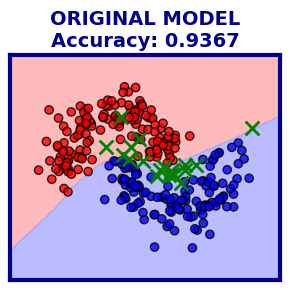

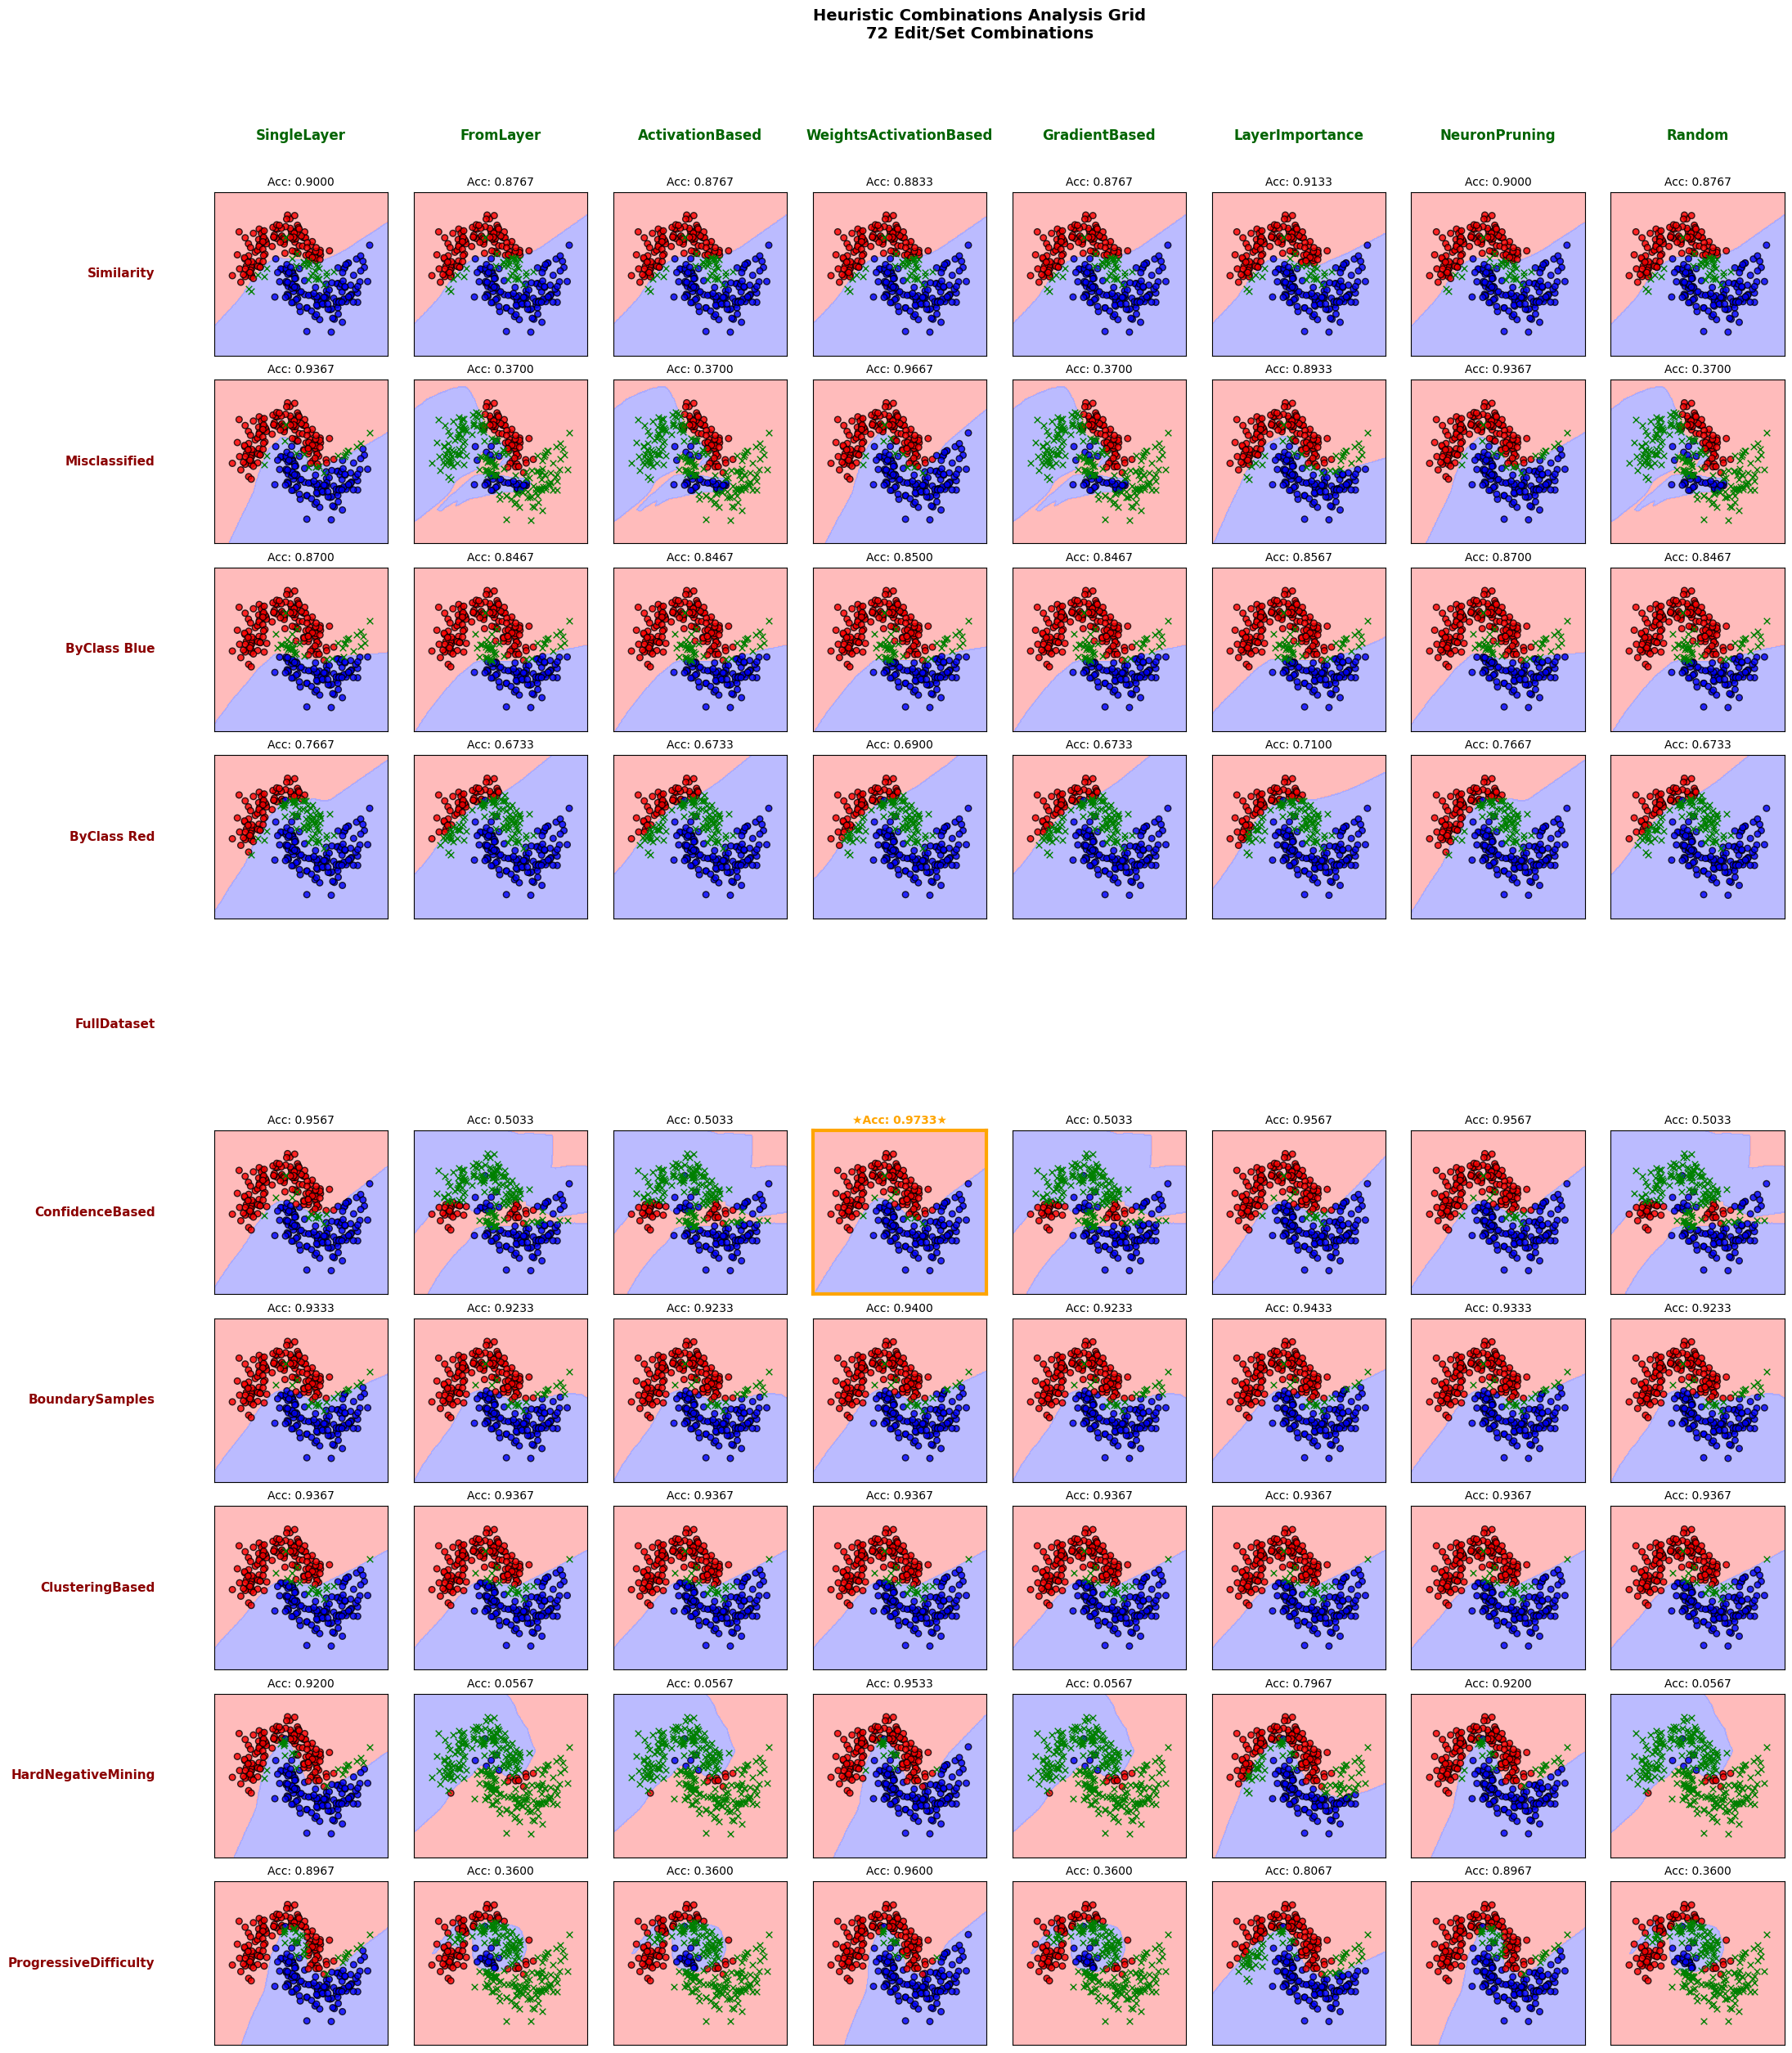

In [4]:
X = moon_data['features']
y = moon_data['labels']

# Find best combination
if not all_results:
    print("\nNo successful combinations found. Please check the heuristic implementations.")
    exit()

# Create visualization with separate figures
num_edit_heuristics = len(edit_heuristics_options)
num_set_heuristics = len(set_heuristics_options)

# Figure 1: Original Model (same size as individual heuristic plots)
fig1, ax_original = plt.subplots(1, 1, figsize=(3, 3))

# Plot original model
ax_original.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
correct_idx = (original_predicted == y.numpy())
ax_original.scatter(X[correct_idx, 0], X[correct_idx, 1], 
                    c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                    edgecolors='k', alpha=0.8)
misclass_idx = (original_predicted != y.numpy())
ax_original.scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                    c='green', marker='x', s=100, linewidths=2)
ax_original.set_title(f"ORIGINAL MODEL\nAccuracy: {original_accuracy:.4f}", 
                        fontweight='bold', fontsize=14, color='darkblue')

# Remove axis labels and ticks for cleaner look
ax_original.set_xticks([])
ax_original.set_yticks([])

# Add border to original model
for spine in ax_original.spines.values():
    spine.set_edgecolor('darkblue')
    spine.set_linewidth(3)

plt.tight_layout()
plt.show()

# Figure 2: Heuristics Grid with better spacing
fig2, axes = plt.subplots(num_set_heuristics, num_edit_heuristics, 
                         figsize=(num_edit_heuristics * 3, num_set_heuristics * 3))

# Plot combinations organized by SetHeuristic (one row per SetHeuristic)
for row, (set_name, _) in enumerate(set_heuristics_options):
    set_results = results_by_set[set_name]
    
    for col, (edit_name, _) in enumerate(edit_heuristics_options):
        ax = axes[row, col]
        
        # Find the result for this combination
        result = None
        for r in set_results:
            if r['edit_heuristic'] == edit_name:
                result = r
                break
        
        if result:
            model = result['model']
            
            with torch.no_grad():
                mesh_output = model(mesh_input)
                Z_result = torch.argmax(mesh_output, dim=1).reshape(xx.shape).detach().numpy()
                outputs = model(X)
                _, predicted = torch.max(outputs.data, 1)
            
            predicted = predicted.numpy()
            
            # Plot decision boundary
            ax.contourf(xx, yy, Z_result, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
            
            # Plot correct classifications
            correct_idx = (predicted == y.numpy())
            ax.scatter(X[correct_idx, 0], X[correct_idx, 1], 
                        c=y.numpy()[correct_idx], cmap=ListedColormap(['#FF0000', '#0000FF']), 
                        edgecolors='k', alpha=0.8, s=30, linewidths=1)
            
            # Plot misclassifications
            misclass_idx = (predicted != y.numpy())
            ax.scatter(X[misclass_idx, 0], X[misclass_idx, 1], 
                        c='green', marker='x', s=30, linewidths=1)
            
            # Highlight best model with orange border
            if result == best_result:
                for spine in ax.spines.values():
                    spine.set_edgecolor('orange')
                    spine.set_linewidth(3)
                title_color = 'orange'
                title = f"★Acc: {result['accuracy']:.4f}★"
                fontweight = 'bold'
            else:
                title_color = 'black'
                title = f"Acc: {result['accuracy']:.4f}"
                fontweight = 'normal'
            
            ax.set_title(title, color=title_color, fontweight=fontweight, fontsize=10)
            
            # Remove axis labels and ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # No result found, hide the subplot
            ax.set_visible(False)

# Adjust spacing to prevent overlaps
plt.subplots_adjust(left=0.18, right=0.98, top=0.825, bottom=0.07, hspace=0.15, wspace=0.15)

# Add column headers (EditHeuristics) centered above each column
for col, (edit_name, _) in enumerate(edit_heuristics_options):
    # Get the axis for the first row in this column
    ax = axes[0, col]
    # Get the bounding box of the axis in figure coordinates
    bbox = ax.get_position()
    x = (bbox.x0 + bbox.x1) / 2
    y = bbox.y1 + 0.02  # slightly above the axis
    fig2.text(x, y, edit_name, ha='center', va='bottom', fontsize=12, fontweight='bold', color='darkgreen')

# Add row headers (SetHeuristics) centered to the left of each row
for row, (set_name, _) in enumerate(set_heuristics_options):
    ax = axes[row, 0]
    bbox = ax.get_position()
    y = (bbox.y0 + bbox.y1) / 2
    # Clean up the set name for display
    display_name = set_name.replace('SetHeuristic', '').replace('_', ' ')
    fig2.text(bbox.x0 - 0.03, y, display_name, ha='right', va='center', fontsize=11, fontweight='bold', color='darkred', rotation=0)

# Add overall title for heuristics grid with proper spacing
fig2.suptitle(
    f'Heuristic Combinations Analysis Grid\n{len(all_results)} Edit/Set Combinations',
    fontsize=14, y=0.9, x=0.57, fontweight='bold'
)

# Add a subtle background for better visual organization
fig2.patch.set_facecolor('white')
fig2.patch.set_alpha(0.9)

plt.show()